# How to Clean up a Dataset

![Baby Bunny](img/kit.jpeg)

## Load Libraries

In [6]:
%matplotlib inline
#generic imports
import csv
import notebook as nb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import json
import sys
import inspect
import math
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.utils import shuffle

import random

dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You have some example documents with classifications and you want to increase the accuracy of predictions you make with this dataset. This is a workshop to find issues in a dataset with python. 

We use a bunny farm chatbot. But sentiment analysis, news, email classification or any supervised learning dataset will have similar issues.

## Bashful Bunnies

A pet rabbit seller on facebook wants to answer common customer questions while they are offline. They give you previous questions they have been asked. And you help them label these by Topic_Verb. This is a whole other talk.

Now you want to quickly go through these labels to find mistakes. Usually 500 questions in 20-50 intents. 

# Tasks
<input type="checkbox"> Load Libraries
<input type="checkbox"> Load Data
<input type="checkbox"> Language specific stuff (spelling, accents, segment words in Chinese etc)
<input type="checkbox"> Run KFold test
<input type="checkbox"> Save Data to show improvements
<input type="checkbox"> Graph questions, Intents and Accuracy
<input type="checkbox"> Find Duplicates
<input type="checkbox"> Find Wrongly labeled
<input type="checkbox"> Find Double Categories
<input type="checkbox"> Find Nonsense
<input type="checkbox"> Find Bad intents
<input type="checkbox"> Look at confusion Matrix
<input type="checkbox"> Label new data 


## Load Data

First off load the data. The file needs to be this name, type and in he local directory. And in the format Question, Intent with a header

In [97]:
filePath = r'bunny.csv'
df = pd.read_csv(filePath,header=0,encoding='utf-8')
df.head()

,Question,Intent
0,Are the baby rabbits certified?,RABBIT_CERTIFICATION
1,What cert does the kit have?,RABBIT_CERTIFICATION
2,Does the rabbit have a certificate? And what f...,RABBIT_CERTIFICATION
3,Is the kit certified by a vet?,RABBIT_CERTIFICATION
4,Has the kit been cleared by a vet?,RABBIT_CERTIFICATION


Ground Truth is utterence (question), intent

  - Real questions from real users
  - Topic_Verb the utterences
 
 10 topics, 50 intents, 2000 Questions but this process here with 500.

# Start Analysis

## Make Kfolds

Make a classifier and get it to classify every quesstion in the training data. 

What it gets wrong we look at to see if our original classificationw as wrong.

In [98]:
#Make five folds
#shuffle the data
df = shuffle(df, random_state=0)
df = df.dropna()
numFolds=5
size=math.trunc(len(df)/numFolds)
#MAke the flds 5 folds
Fold1=df[:size]
Fold2=df[size:(size*2)]
Fold3=df[(size*2):(size*3)]
Fold4=df[(size*3):(size*4)]
Fold5=df[(size*4):]

### now we have folds define a classifier

In [92]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
porter = PorterStemmer()
lancaster=LancasterStemmer()
#proide a word to be stemmed
print("Porter Stemmer")
print(porter.stem("cats"))

class LemmaTokenizer(object):
    def __init__(self):
            self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [102]:


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),# tokenizer=LemmaTokenizer() ,ngram_range=(1, 2)  ,stop_words=stopWords ngram_range=(1, 1)
                    ('clf',  SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, tol=0.001, max_iter=1000, random_state=42)),#n_iter=20 'hinge'
                    #('clf',  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
                    ]) 


In [103]:
#This is what makes train smaller
train = pd.concat([Fold2, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)


df1 = pd.DataFrame(columns=['Question', 'GTIntent', 'Prediction 1','Conf 1','Pred2','conf2','match'])

total=0


def runFold(test):
    i=0
    global total,df1

    for row in test.iterrows():
        row2=[test.iloc[i,0]]
        #row2=[row]
        predicted=text_clf.predict(row2)
        values= text_clf.predict_proba(row2)
        best_n = np.argsort(values, axis=1)[:,-3:]
    
        if test.iloc[i,1]==predicted[0]:
                match=1
                total=total+1
        else:
                match=0
            

        df1 = df1.append({'Question' : row2[0] , 'GTIntent' : test.iloc[i,1],'Prediction 1':text_clf.classes_[best_n.item(2)],'Conf 1':math.trunc(values[0][best_n.item(2)]*100),'Pred2':text_clf.classes_[best_n.item(1)],'conf2':math.trunc(values[0][best_n.item(1)]*100),'match':match} , ignore_index=True)#,'':,'':,'':,'':,'':


        i=i+1

        
train = pd.concat([Fold2, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold1)
train = pd.concat([Fold1, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold2)
train = pd.concat([Fold1, Fold2, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold3)
train = pd.concat([Fold1, Fold2, Fold3,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold4)
train = pd.concat([Fold1, Fold2, Fold3,Fold4]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold5)


print("accuracy is "+str(total/(len(Fold1)*5)))
df1.to_excel('checkThese.xlsx', encoding='utf-8', index=False)#



accuracy is 0.6521739130434783


In [ ]:
## save data in a csv 
## Date, Accuracy, intent numbers, question numbers
import datetime as dt
now=dt.datetime.today().strftime("%m/%d/%Y")

with open("result_statistics.csv", "a") as myfile:
    myfile.write(now+","+str(df['Intent'].nunique())+","+str(len(df))+","+str(math.trunc((total/(len(Fold1)*5)*100)))+"\n")    

![rabbit eating](img/coco2.jpg)

## Find Errors

Three kinds of errors

Duplicates

Confident and wrong

Second Confidence High

Low confidence nonesense

In [60]:
df1.tail()

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
112,Any rabbits to sell?,PURCHASE_RABBIT,PURCHASE_RABBIT,100,RABBIT_SOCIALISATION,0,1
113,has the kit had to go see a vet?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,1
114,Did the rabbit have to visit a vet?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,1
115,Do you verify that the kit does not have fleas?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,1
116,Can you guarantee the rabbit doesn't have worms?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,1


In [61]:
dupes = pd.DataFrame()
dupes=df[df.duplicated('Question', keep=False)]
dupes = dupes.sort_values('Question',ascending=False)

htmld = dupes.to_html()

dupes

,Question,Intent
115,Any rabbits to sell?,PURCHASE_RABBIT
113,Any rabbits to sell?,PURCHASE_RABBIT


![dog](img/dog.jpg) 

In [62]:
#Find high confidence wrong
highWrong = df1[(df1['Conf 1'] > 95) & (df1['match'] ==0)]
highWrong=highWrong.sort_values(by=['Conf 1'],ascending=False)

htmlhw = highWrong.to_html()

highWrong    

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
3,Do you have details on your breeding business?,BREEDER_INFORMATION,BREEDER_REFERENCES,100,RABBIT_SOCIALISATION,0,0
55,Has the kit been cleared by a vet?,RABBIT_CERTIFICATION,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0
87,What is your guarantee?,BREEDER_GUARANTEE,BREEDER_INFORMATION,100,RABBIT_SOCIALISATION,0,0
83,Do I need to spay/neuter the kit? /limited reg...,BREEDER_INFORMATION,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0
72,Can you give me any references?,BREEDER_REFERENCES,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0
69,Is the rabbit s injections covered?,RABBIT_HEALTH,RABBIT_SOCIALISATION,100,RABBIT_PARENTS,0,0
67,How does the rabbit handle strangers?,RABBIT_SOCIALISATION,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0
61,Has a vet certified the rabbit ?,RABBIT_CERTIFICATION,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0
49,What is your mission statement?,BREEDER_INFORMATION,BREEDER_GUARANTEE,100,RABBIT_SOCIALISATION,0,0
9,What has the baby rabbits been fed?,RABBIT_FOOD,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0


![two at once](img/maxresdefault.jpg) 

In [66]:
#Find intents where second intent is high confidence

doubleq = df1[df1.conf2 > 20]
doubleq=doubleq.sort_values(by=['conf2'],ascending=False)
htmldq = doubleq.to_html()

doubleq    
    

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
103,Do you allow access from vets?,RABBIT_HEALTH,RABBIT_PARENTS,50,BREEDER_REFERENCES,50,0
16,Why breed these rabbit s?,BREEDER_INFORMATION,PURCHASE_RABBIT,47,BREEDER_INFORMATION,47,1
79,What food do I need to get?,RABBIT_FOOD,RABBIT_FOOD,57,RABBIT_HEALTH,42,1
73,Are the kits siblings sick?,RABBIT_HEALTH,RABBIT_HEALTH,65,RABBIT_CERTIFICATION,34,1
96,Much for a rabbit?,PURCHASE_RABBIT,RABBIT_FOOD,44,RABBIT_HEALTH,34,0
84,Ba mhaith liom coinin. Ach nil aon airgead agam,PURCHASE_RABBIT,RABBIT_HEALTH,26,BREEDER_REFERENCES,25,0


Why two questions at once?
  -  Customers see one task when business sees two. 'I want to cancel my card and get a new one'
  -  People complain about two things at once. 'The food is terrible and the portions are too small'
  -  Chatbot is not clear enough to ask one question at a time. This is the big reason to admit you are a chatbot
  -  Just asked two questions when they shouldnt have

![rabbit eating](img/0000049339.jpg)

In [67]:
#Find intents that are low confidence and wrong. Might be nonsense

verylow = df1[(df1['Conf 1'] < 36) & (df1['match'] ==0)]
verylow=verylow.sort_values(by=['conf2'],ascending=False)
dflc = verylow.to_html()
verylow

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
84,Ba mhaith liom coinin. Ach nil aon airgead agam,PURCHASE_RABBIT,RABBIT_HEALTH,26,BREEDER_REFERENCES,25,0
2,What does the rabbit like to eat?,RABBIT_FOOD,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
53,Do I need to get the rabbit dewormed?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
105,What guarantee do you offer?,BREEDER_GUARANTEE,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
95,"I'd like to talk to another owner, is that pos...",BREEDER_REFERENCES,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
77,Do you have a food/mix ratio I need to be awar...,RABBIT_FOOD,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
65,Are the baby rabbits certified?,RABBIT_CERTIFICATION,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
62,Can you tell me if the kit was not well?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
54,Do I need to worry about fleas?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
34,What visits to the vets took place?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0


In [24]:
with open("all.html", 'w') as _file:
    _file.write( "<h1>Duplicates</h1>"+htmld + "\n\n<h1>Double Questions</h1>" + htmldq+ "\n\n<h1>High Confidence Wrong</h1>"+ htmlhw+ "\n\n<h1>Could be Nonsense</h1>"+ dflc)

## Find Bad Intents

![rabbit eating](img/bunny2.jpg)

![Low and right should be looked at](img/fixthese2.png)


In [68]:
wrong = df1[(df1['GTIntent']!=df1['Prediction 1'])]
correct = df1[(df1['GTIntent']==df1['Prediction 1'])]

wf=wrong.groupby(['GTIntent'], as_index=False).count()
crf=correct.groupby(['GTIntent'], as_index=False).count()
gf1=wf[['GTIntent','Question']]
gf1.columns = ['Intent', 'wrong']


crf1=crf[['GTIntent','Question']]
crf1.columns = ['Intent', 'right']
#crf1.head()
result = pd.merge(crf1,gf1,on='Intent',how='outer')
result=result.fillna(0)
#total questions
result['total'] = result['wrong'] + result['right']
#calculate percentage we got right
result['percent'] = (result['right']/(result['wrong'] + result['right']))*100

result=result.round(0)

In [69]:
lowAcc = result[(result.percent < 100) & (result['wrong'] >1)]
lowAcc=lowAcc.sort_values(by=['total'],ascending=False)
lowAcc

,Intent,right,wrong,total,percent
5,RABBIT_HEALTH,25.0,19,44.0,57.0
6,RABBIT_PARENTS,10.0,5,15.0,67.0
0,BREEDER_INFORMATION,3.0,9,12.0,25.0
2,PURCHASE_RABBIT,8.0,2,10.0,80.0
7,RABBIT_SOCIALISATION,6.0,3,9.0,67.0
3,RABBIT_CERTIFICATION,1.0,7,8.0,12.0
1,BREEDER_REFERENCES,3.0,4,7.0,43.0
4,RABBIT_FOOD,1.0,5,6.0,17.0
8,BREEDER_GUARANTEE,0.0,6,6.0,0.0


## Confusion Matrix

Once you fix these basic misclassifications the next common issue is mixed up intents.

                  Actual
             Intent1 Intent2 ...     
     Intent1  
     Intets2      
     ...  
       
predicted     
       
       
       
  
 Open checkthese spreadsheet and select two intents that are mixes up
 

In [70]:
df1.head()

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
0,What are the size of the parents?,RABBIT_PARENTS,RABBIT_PARENTS,100,RABBIT_SOCIALISATION,0,1
1,Has the litter been not well?,RABBIT_HEALTH,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,1
2,What does the rabbit like to eat?,RABBIT_FOOD,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
3,Do you have details on your breeding business?,BREEDER_INFORMATION,BREEDER_REFERENCES,100,RABBIT_SOCIALISATION,0,0
4,Do rabbits get health documentation,RABBIT_CERTIFICATION,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0


In [71]:


def get_confusion_matrix(y_true, y_pred, labels, normalize=False):
    conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels)
    if normalize:
        conf_matrix = conf_matrix.astype('float')/conf_matrix.sum(axis=1)[:, np.newaxis]
    conf = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    return conf

In [73]:
conf=df1#res[0]
cf = get_confusion_matrix(conf['GTIntent'], conf['Prediction 1'], labels=conf['GTIntent'].unique())
#df['Diag'] =pd.Series(np.diag(cf), index=[cf.index, cf.columns])
cf.tail()

conf = cf.to_csv('Confusion.csv', encoding='utf-8')

## Label Data

![rabbit eating](img/baby-bunny.jpg)

Now you have a classifier use it to classify new data. Then you can go through this labeled data and agree/disagree with it. This is much faster than labeling data yourself cold.

In [47]:
filePath = r'tolabel.csv'

label = pd.read_csv(filePath,header=0)

#label=label.drop(['Unnamed: 0'], axis=1)
label = label.dropna()        
label.head(20)


,Question
0,Do the baby rabbits get a certificate?
1,What cert do the kits have?
2,Does the rabbit have a certificate?
3,Is the kit approved by a vet?
4,Has the kit been given the OK by a vet?
5,Has a veterinarian certified the rabbit ?


In [48]:
#train = pd.concat([trainSent]) 
text_clf.fit(df.Question, df.Intent)        


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...om_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

Label all the new data. And then go through it by intent agreeing or disagreeing with the label

In [49]:
labeled = pd.DataFrame(columns=['Question', 'Prediction 1','Conf 1','Pred2','conf2'])
i=0


for row in label.iterrows():
    row2=[label.iloc[i,0]]
    predicted=text_clf.predict(row2)
    values= text_clf.predict_proba(row2)
    best_n = np.argsort(values, axis=1)[:,-3:]            
    labeled = labeled.append({'Question' : row2[0] ,'Prediction 1':text_clf.classes_[best_n.item(2)],'Conf 1':math.trunc(values[0][best_n.item(2)]*100),'Pred2':text_clf.classes_[best_n.item(1)],'conf2':math.trunc(values[0][best_n.item(1)]*100)} , ignore_index=True)
    i=i+1


In [50]:
labeled.tail()

,Question,Prediction 1,Conf 1,Pred2,conf2
1,What cert do the kits have?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11
2,Does the rabbit have a certificate?,RABBIT_CERTIFICATION,100,RABBIT_SOCIALISATION,0
3,Is the kit approved by a vet?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11
4,Has the kit been given the OK by a vet?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11
5,Has a veterinarian certified the rabbit ?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11


# Below if we have time

## Accuracy of intents graphs and tables

In [36]:

#date,intents,questions,accuracy
filePath = r'result_statistics.csv'
plotdata = pd.read_csv(filePath,header=0)

#df = df.iloc[1:]
plotdata.head()

,date,intents,questions,accuracy
0,10/03/2019,2,13000,70
1,10/07/2019,3,500,67
2,10/07/2019,3,404,66
3,10/07/2019,3,320,65
4,10/07/2019,3,504,70


In [41]:
from random import random
colors=[]
when = plotdata.iloc[:,0]
#make a random list of colors
for i in enumerate(when):
    nextC=random(),random(),random()
    colors.append(nextC)
    
   

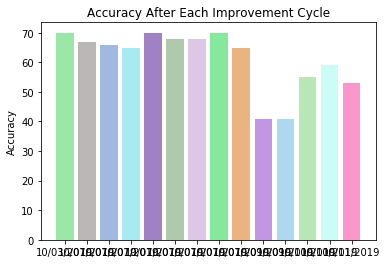

In [42]:
when = plotdata.iloc[:,0]
performance = plotdata.iloc[:,3]

y_pos = np.arange(len(when))
plt.bar(y_pos, performance, align='center', alpha=0.5, color=colors)


plt.xticks(y_pos, when)
plt.ylabel('Accuracy')
plt.title('Accuracy After Each Improvement Cycle')



plt.savefig('AccuracyExamplesOct02.png')
plt.savefig('AccuracyExamplesOct02.pdf')